In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd, mode

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *
import dask.dataframe as dd

%run cmip_metrics.py
%run model_by_model_analysis_helper.py

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
FLUX_TO_MM_YR = FLUX_TO_MM_HR*24*365
HOURS_TO_RADIANS = 2*np.pi/24

In [2]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'

input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
# input_data_dir_cm6 = rel_data_dir + 'diurnal_analysis_results/CMIP6_clt_regridded/grid1/'

input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results/GPM_regridded/grid1/GPM/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'


input_data_dir_rlut = '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rlut/'
input_data_dir_rsut = '/export/data1/cchristo/CMIP6_radiation/averages/time_averages/period/rsut/' 
input_data_dir_pr = '/export/data1/cchristo/CMIP6_precip/averages/time_averages/period/pr/'
input_data_dir_clt ='/export/data1/cchristo/CMIP6_clouds/averages/time_averages/period/clt/' 

In [26]:
os.listdir(input_data_dir_gpm)

['grid1_2000-06_2010-06_precip.nc']

In [ ]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_clouds/clt_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [ ]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




In [129]:
# ds_gpm['phase_season']

## Take mean accross seasons for GPM (circular for phase!)

In [9]:
ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2010-06_precip.nc') #.mean(dim = 'season')

### compute means
# # take mean across seasons using circular mean for phase
ds_gpm_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_gpm['phase_season'], 
#                                    kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True)
# compute yearly mean other data 
ds_gpm = ds_gpm.mean(dim = 'season')
ds_gpm['phase_season'] = ds_gpm_phase_year_mean

#########

ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
df_gpm = ds_gpm.to_dataframe()

df_gpm_land = df_gpm[df_gpm['land_sea_mask'] == 1]
df_gpm_water= df_gpm[df_gpm['land_sea_mask'] == 0]

In [10]:
def _merge_models_into_df(model_names, input_data_dir,
                          filename = '1985-01_2006-01_precip.nc',
                          compute_year_mean_bool = False, 
                          verbose = False):
    '''Given list of model names and path to cmip files containing seasonal components, 
    open and take yearly mean (ensuring a circular mean is used for phase).'''
    objs = {}
    df = pd.DataFrame()
    for model_name_i in range(len(model_names)):  
        try:
            model_name = model_names[model_name_i]
            path_to_file = input_data_dir + model_name + '/' + filename
            ds_i = xr.open_dataset(path_to_file)
            if compute_year_mean_bool:
                ds_i_phase_year_mean = xr.apply_ufunc(phase_circmean, ds_i['phase_season'], 
#                                    kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True,
                                   dask = 'allowed')
                ds_i = ds_i.mean(dim = 'season')
                ds_i['phase_season'] = ds_i_phase_year_mean
            objs[model_names[model_name_i]] = ds_i.to_dataframe()
            objs[model_names[model_name_i]]['model_name'] = model_name
        
        except Exception as e:
            if verbose:
                print('Could not get ', model_name_i, ' : ', e)
    df = pd.concat(list(objs.values()), axis = 0)
    return df
    

In [11]:
%%time
# # compute yearly mean
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = True,
                               verbose = False)
# use only one season 
# df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
#                                input_data_dir = input_data_dir_cm6, 
#                                filename = 'grid1_1985-01_2006-01_precip.nc', 
#                                compute_year_mean_bool = False,
#                                verbose = False)

df_cm6['cmip_indentifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_indentifier'] = 'CMIP5'


# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# use only cmip6
# df_models = df_cm6.copy()

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

CPU times: user 7min 19s, sys: 4.13 s, total: 7min 23s
Wall time: 7min 23s


In [13]:
# df_models.index


In [158]:
# ys
# ds_i.to_dataframe

# list(objs.values())[0]
# df
# ds_gpm['phase_season'].isel(season = 3).plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)

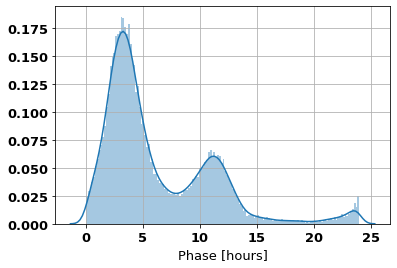

In [13]:
# df[df['model_name'] == 'GFDL-CM4'].plot(y = 'phase_season', kind = 'hist', bins = 30)
sns.distplot(df[df['model_name'] == 'GFDL-ESM4']['phase_season'].values, bins = 150)
plt.xlabel('Phase [hours]')
plt.grid()



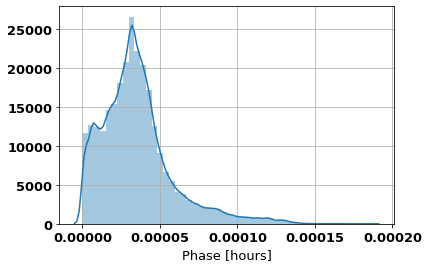

In [14]:
sns.distplot(df[df['model_name'] == 'GFDL-CM4']['mu_season'].values)
plt.xlabel('Phase [hours]')
plt.grid()

2.6193638396735426


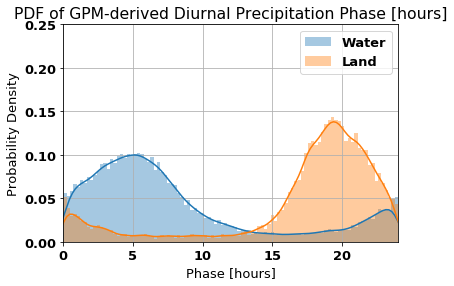

In [15]:
nbins = 100

sns.distplot(df_gpm[df_gpm['land_sea_mask'] == 0]['phase_season'].values, label = 'Water', bins = nbins)
sns.distplot(df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values, label = 'Land', bins = nbins)
# sns.distplot(df_gpm['phase_season'].values, label = 'All', bins = 100)
print(phase_circmean(df_gpm['phase_season']))
plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of GPM-derived Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
# plt.savefig(save_figs_dir + 'GPM/' + 'phase_pdf_land_ocean.png', dpi = 300)

In [429]:
# sns.distplot(df_gpm[df_gpm['land_sea_mask'] == 0]['phase_season'].values, label = 'Water', bins = 200)
# plt.yscale('log')


4.365125666155656


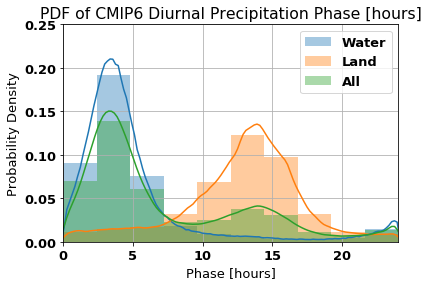

In [18]:
nbins = 10
sns.distplot(df[(df['land_sea_mask'] == 0) & (df['cmip_indentifier'] == 'CMIP6')]['phase_season'].values, label = 'Water', bins = nbins)
sns.distplot(df[(df['land_sea_mask'] == 1) & (df['cmip_indentifier'] == 'CMIP6')]['phase_season'].values, label = 'Land', bins = nbins)
sns.distplot(df['phase_season'].values, label = 'All', bins = nbins)
print(phase_circmean(df['phase_season']))

plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of CMIP6 Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
# plt.savefig(save_figs_dir + 'CMIP6/comparisions/' + 'phase_pdf_land_ocean.png', dpi = 300)

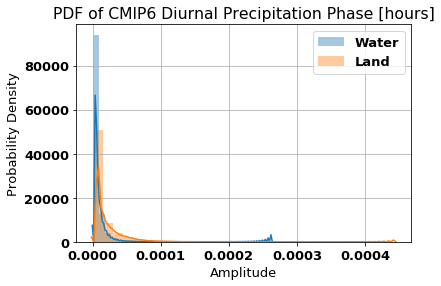

In [356]:
land_sea_histogram(df, field_id = 'ampl_season', nbins = 30)
# df

In [358]:
# land_sea_histogram(filter_by_season(df, 'JJA'), nbins = 50)
# land_sea_histogram(df_gpm, field_id = 'ampl_season', nbins = 30)


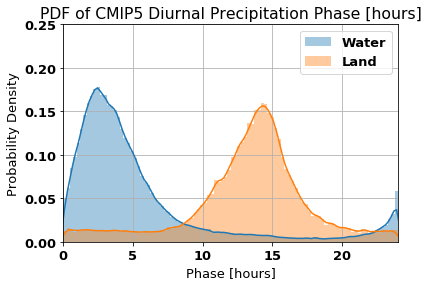

In [73]:
sns.distplot(df[(df['land_sea_mask'] == 0) & (df['cmip_indentifier'] == 'CMIP5')]['phase_season'].values, label = 'Water', bins = 100)
sns.distplot(df[(df['land_sea_mask'] == 1) & (df['cmip_indentifier'] == 'CMIP5')]['phase_season'].values, label = 'Land', bins = 100)
plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of CMIP5 Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
# plt.savefig(save_figs_dir + 'CMIP5/comparisons/' + 'phase_pdf_land_ocean.png', dpi = 300)

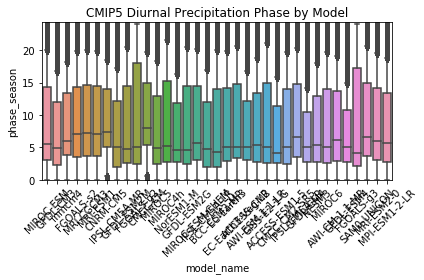

In [67]:
sns.boxplot(x = 'model_name', y = 'phase_season', data = df, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP5 Diurnal Precipitation Phase by Model')
# plt.grid()
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_cmip5.png', dpi = 300)

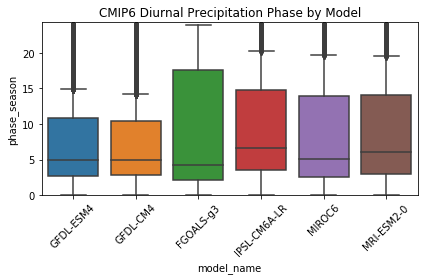

In [114]:
sns.boxplot(x = 'model_name', y = 'phase_season', data = df_cm6, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP6 Diurnal Precipitation Phase by Model')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_cmip6.png', dpi = 300)

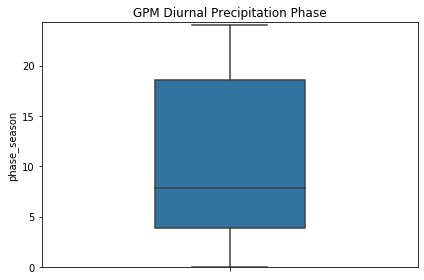

In [265]:

sns.boxplot(y = 'phase_season', data = df_gpm, whis = 0.5, width = 0.4)
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('GPM Diurnal Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_gpm.png', dpi = 300)

In [70]:
# df_cm6


In [74]:
# plt.figure(figsize = (8,5))
# sns.boxplot(x = 'model_name', y = 'phase_season', hue = 'land_sea_mask', data = df_cm6, whis = 0.5)
# # sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
# plt.ylim(0, 24.3)
# plt.xticks(rotation = 45)
# plt.title('CMIP6 Diurnal Precipitation Phase by Model [land/sea]')
# plt.tight_layout()
# plt.legend(loc  = 1)
# plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_land_sea_cmip6.png', dpi = 300)

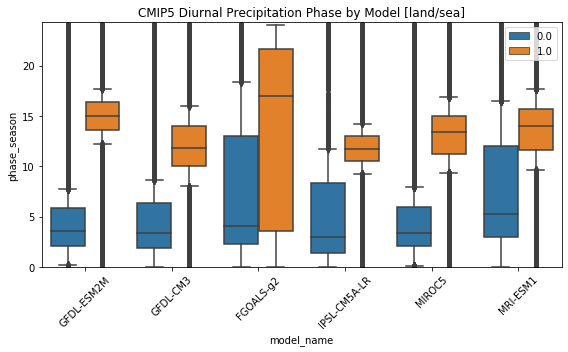

In [149]:
plt.figure(figsize = (8,5))
sns.boxplot(x = 'model_name', y = 'phase_season', hue = 'land_sea_mask', data = df_cm5, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP5 Diurnal Precipitation Phase by Model [land/sea]')
plt.tight_layout()
plt.legend(loc  = 1)
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_land_sea_cmip5.png', dpi = 300)

In [159]:
# df_gpm
df_gpm['source'] = 'gpm'

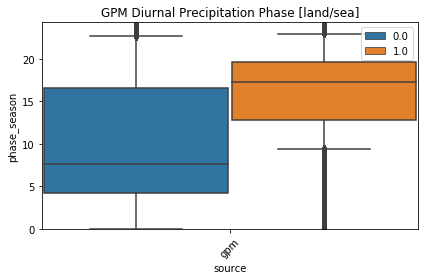

In [160]:

sns.boxplot(x = 'source', y = 'phase_season', data = df_gpm, whis = 0.5, hue = 'land_sea_mask', width = 1)
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('GPM Diurnal Precipitation Phase [land/sea]')
plt.tight_layout()
plt.legend(loc  = 1)
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_gpm_land_sea.png', dpi = 300)

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

# compute error statistics


In [261]:
df_cmip6 = df[df['cmip_indentifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_indentifier'] == 'CMIP5']
field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
df_for_stats_true = df_gpm.copy()

df_for_stats['ampl_season'] = FLUX_TO_MM_HR*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_HR*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]


# df_for_stats_true = df_gpm[df_gpm['season'] == season]

# compute precip weights
df_for_stats_true['precip_weights'] = df_for_stats_true['mu_season']/df_for_stats_true['mu_season'].sum()

# merge gpm precip weights into model df 
df_for_stats = pd.merge(df_for_stats, 
                        df_for_stats_true['precip_weights'], 
                        how = 'left', 
                        left_index = True, 
                        right_index = True)


df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
df_lat_lon_mode_phase = df_for_stats.round(1).groupby(['lat','lon'])['phase_season'].agg(mode_apply)
df_lat_lon_mode_ampl = df_for_stats.round(4).groupby(['lat','lon'])['ampl_season'].agg(mode_apply)

# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)
cmips_mode_df = pd.DataFrame()
cmips_mode_df['phase_mode'] = df_lat_lon_mode_phase
cmips_mode_df['ampl_mode'] = df_lat_lon_mode_ampl
cmips_mode_ds = xr.Dataset.from_dataframe(cmips_mode_df)

ampl_weighted_mean_df = df_for_stats[['ampl_season', 'precip_weights', 'model_name']].groupby('model_name').apply(ampl_weighted_mean_func)

In [54]:
# df_for_stats.index


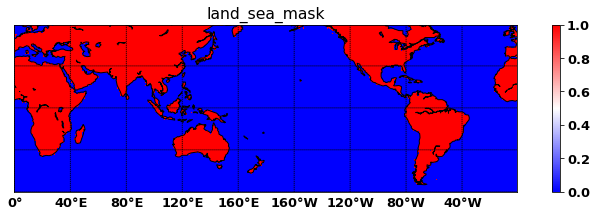

In [31]:
make_single_plot(ds_land_sea['GLDAS_mask'] ,
                 title = 'land_sea_mask',
                 vmin = 0, vmax = 1, 
                 cmap  =plt.get_cmap('bwr'))

In [405]:
# ds_gpm.isel(season = 0)

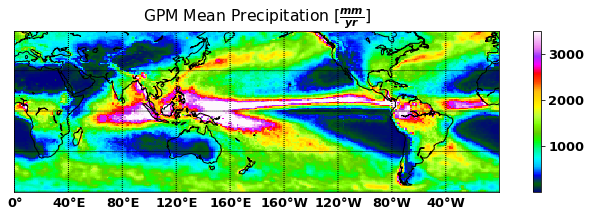

In [250]:
make_single_plot(ds_gpm['mu_season']*24*365, 
                 title = r'GPM Mean Precipitation [$\frac{mm}{yr}$]',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4*24*365)
# plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)

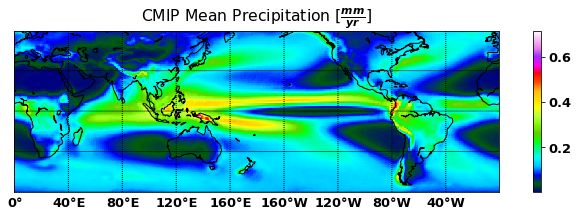

In [253]:
make_single_plot(cmips_mean_ds['mu_season'] , #*24*365, 
                 title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
                  cmap = plt.get_cmap('gist_ncar'),)# vmax = 0.4*24*365)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'mu_mean_spatial.png', dpi = 300)

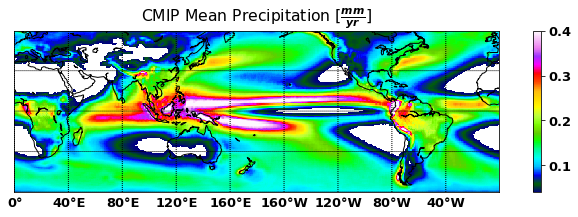

In [294]:
make_single_plot(cmips_mean_ds['mu_season'].where(cmips_mean_ds['mu_season'] > 0.04), 
                 title = r'CMIP Mean Precipitation [$\frac{mm}{yr}$]',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

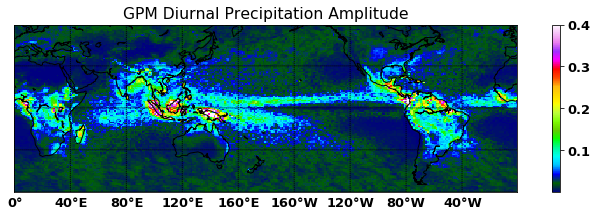

In [34]:
make_single_plot(ds_gpm['ampl_season'], 
                 title = r'GPM Diurnal Precipitation Amplitude',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
# plt.savefig(save_figs_dir + 'GPM/' + 'ampl_mean_spatial.png', dpi = 300)

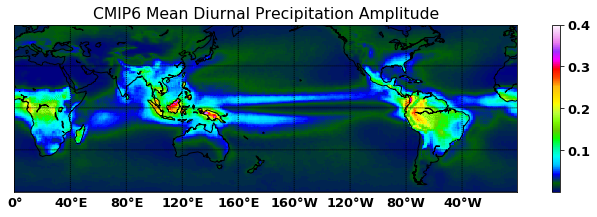

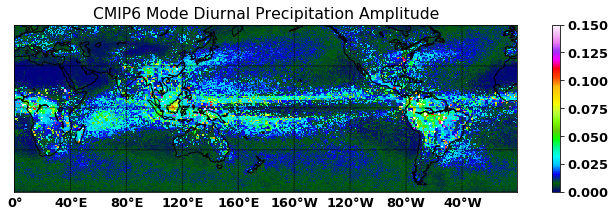

In [61]:
# plot mean
make_single_plot(cmips_mean_ds['ampl_season'], 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

# plot mode
make_single_plot(cmips_mode_ds['ampl_mode'], 
                 title = r'CMIP6 Mode Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.15)


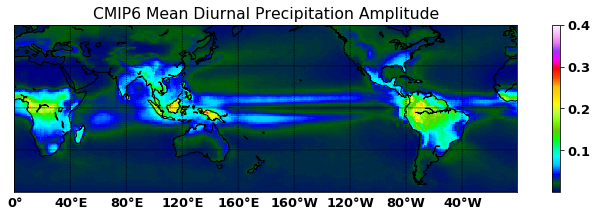

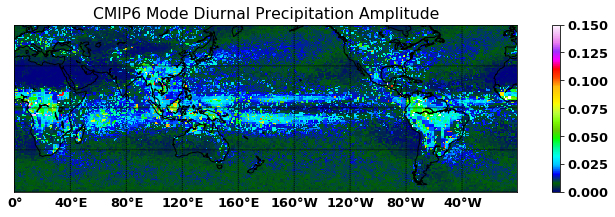

In [105]:
make_single_plot(cmips_mean_ds['ampl_season'], 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

# plot mode
make_single_plot(cmips_mode_ds['ampl_mode'], 
                 title = r'CMIP6 Mode Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.15)

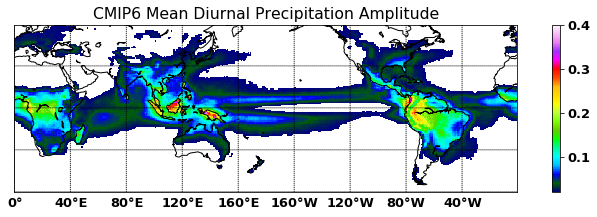

In [342]:
make_single_plot(cmips_mean_ds['ampl_season'].where(cmips_mean_ds['ampl_season']> 0.02), 
                 title = r'CMIP6 Mean Diurnal Precipitation Amplitude',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)

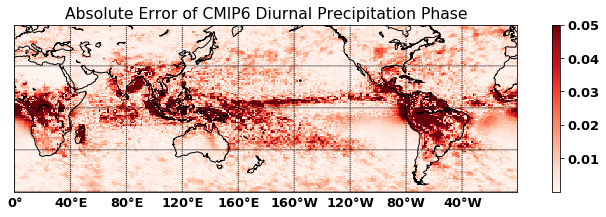

In [36]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'),vmax = 0.05)
# plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

In [37]:
%run diurnal_utils.py

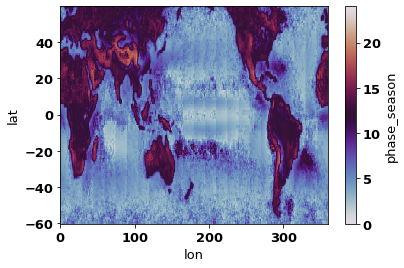

In [38]:
cmips_mean_ds[field].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
# (cmips_mean_ds[field]*10000).plot.imshow(cmap = plt.get_cmap('gist_ncar'))

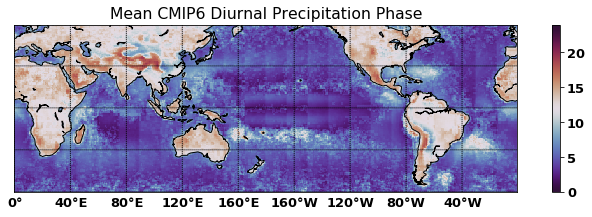

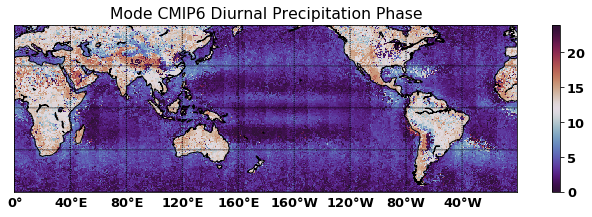

In [63]:
# # plot mean
make_single_plot(cmips_mean_ds['phase_season'], 
                 title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# isinstance(cmips_mean_ds[field])
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)


# plot mode
make_single_plot(cmips_mode_ds['phase_mode'], 
                 title = r'Mode CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)


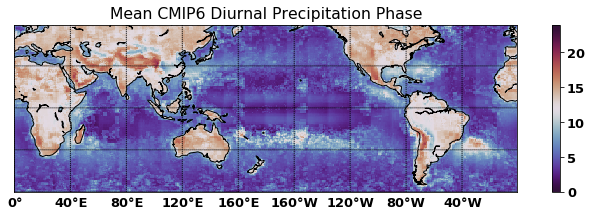

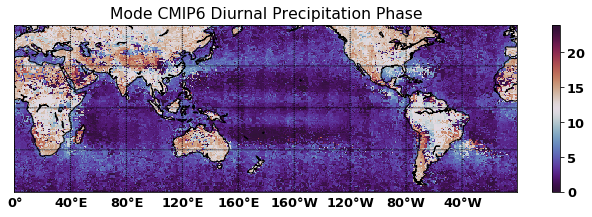

In [69]:
make_single_plot(cmips_mean_ds['phase_season'], 
                 title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# isinstance(cmips_mean_ds[field])
# plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)


# plot mode
make_single_plot(cmips_mode_ds['phase_mode'], 
                 title = r'Mode CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

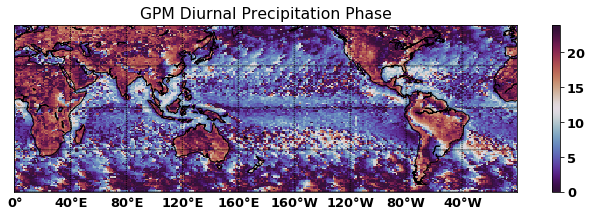

In [41]:
make_single_plot(ds_gpm['phase_season'], 
                 title = r'GPM Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# plt.savefig(save_figs_dir + 'GPM/' + 'phase_mean_spatial.png', dpi = 300)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'))

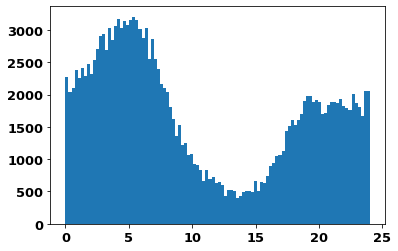

In [224]:
_ = plt.hist(ds_gpm['phase_season'].values.flatten(), bins = 100)

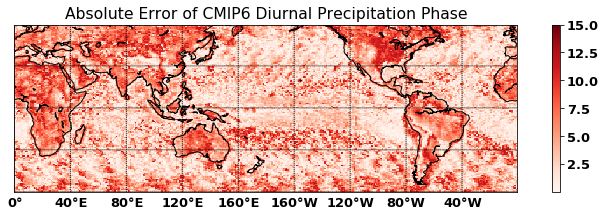

In [196]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
make_single_plot(cmips_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 15)
#                  vmin = 0, vmax = 3)
# plt.savefig(save_figs_dir + 'compare_models/' + 'phase_abs_error_spatial.png', dpi = 300)

# Taylor Plots

In [42]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm['phase_season'], low = 0.0, high = 24.0)
gpm_land_std = circstd(df_gpm_land['phase_season'], low = 0.0, high = 24.0)
gpm_water_std = circstd(df_gpm_water['phase_season'],low = 0.0, high = 24.0)

In [274]:
min_lat, max_lat = -60, 60

rlut_dict = _get_mean_field(input_data_dir_rlut,
                       field_name = 'rlut',
                       filter_lat = True,
                       **{'min_lat': min_lat,
                       'max_lat': max_lat})
rsut_dict = _get_mean_field(input_data_dir_rsut,
                       field_name = 'rsut',
                       filter_lat = True,
                       **{'min_lat': min_lat,
                       'max_lat': max_lat})
pr_dict = _get_mean_field(input_data_dir_pr,
                       field_name = 'pr',
                       filter_lat = True,
                       **{'min_lat': min_lat,
                       'max_lat': max_lat})
clt_dict = _get_mean_field(input_data_dir_clt,
                       field_name = 'clt',
                       file_name = '1985-01_2006-01_mean.nc',
                       filter_lat = True,
                       **{'min_lat': min_lat,
                       'max_lat': max_lat})

# min_lat, max_lat = 35, 60

# rlut_dict = _get_mean_field(input_data_dir_rlut,
#                        field_name = 'rlut',
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat, 
#                        'absolute_value': True})
# rsut_dict = _get_mean_field(input_data_dir_rsut,
#                        field_name = 'rsut',
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat, 
#                        'absolute_value': True})
# pr_dict = _get_mean_field(input_data_dir_pr,
#                        field_name = 'pr',
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat, 
#                        'absolute_value': True})
# clt_dict = _get_mean_field(input_data_dir_clt,
#                        field_name = 'clt',
#                        filter_lat = True,
#                        **{'min_lat': min_lat,
#                        'max_lat': max_lat, 
#                        'absolute_value': True})



stats_kwargs = {'ecs_dict': cmip6_ecs, 'tcr_dict': cmip6_tcr, 
     'rlut_dict': rlut_dict, 'rsut_dict': rsut_dict, 
     'pr_dict': pr_dict, 'clt_dict': clt_dict}

In [27]:
# test['lat'].ma()
# _ = test['lat'].plot.hist(bins = 200)
# plt.grid()
# rlut_dict

# pr_dict


In [148]:
%run model_by_model_analysis_helper.py

df_for_stats_land = df_for_stats[df_for_stats['land_sea_mask'] == 1]
df_for_stats_water = df_for_stats[df_for_stats['land_sea_mask'] == 0]

df_for_stats_true_land = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 1]
df_for_stats_true_water = df_for_stats_true[df_for_stats_true['land_sea_mask'] == 0]



In [249]:
df_sub = df_for_stats[df_for_stats['model_name'] == 'MIROC6']['mu_season']

lat    lon  
-60.0  0.0      0.112907
       0.5      0.112907
       1.0      0.113887
       1.5      0.113887
       2.0      0.113887
                  ...   
 59.5  357.5    0.126858
       358.0    0.122048
       358.5    0.122048
       359.0    0.122048
       359.5    0.123957
Name: mu_season, Length: 172800, dtype: float64

In [248]:
pr_sub = xr.Dataset.from_dataframe([df_for_stats['model_name'] == 'MIROC6']['mu_season'])

TypeError: list indices must be integers or slices, not str

mu_season  sigma_season  ampl_season  phase_season  \
lat   lon                                                         
-60.0 0.0     0.112907      0.000002     0.009930      4.233286   
      0.0     0.102087      0.000001     0.005797      5.535182   
      0.0     0.104325      0.000002     0.007501      4.568643   
      0.5     0.112907      0.000002     0.009930      4.233286   
      0.5     0.100216      0.000002     0.007121      5.441180   
...                ...           ...          ...           ...   
 59.5 359.5   0.114053      0.000002     0.006076      2.850959   
      359.5   0.140611      0.000002     0.008004      0.297423   
      359.5   0.125070      0.000001     0.005356     10.788841   
      359.5   0.119336      0.000002     0.007891      4.107314   
      359.5   0.133327      0.000003     0.011762      1.820820   

                  model_name cmip_indentifier  land_sea_mask  precip_weights  
lat   lon                                                                     
-60.0 0.0             MIROC6            CMIP6              0        0.000005  
      0.0    MPI-ESM-1-2-HAM            CMIP6              0        0.000005  
      0.0         MIROC-ES2L            CMIP6              0        0.000005  
      0.5             MIROC6            CMIP6              0        0.000005  
      0.5         KACE-1-0-G            CMIP6              0        0.000005  
...                      ...              ...            ...             ...  
 59.5 359.5        FGOALS-g3            CMIP6              0        0.000007  
      359.5      SAM0-UNICON            CMIP6              0        0.000007  
      359.5     IPSL-CM6A-LR            CMIP6              0        0.000007  
      359.5       MIROC-ES2L            CMIP6              0        0.000007  
      359.5       ACCESS-CM2            CMIP6              0        0.000007  

[2779645 rows x 8 columns]

In [266]:
# df_for_stats[df_for_stats['mu_season'] > 0.1]

In [368]:
# compute stats for all points
# df_for_stats[df_for_stats['ampl_season']> 0.001
%run model_by_model_analysis_helper.py
model_error_stats_df= compute_stats(df_for_stats,
                 df_for_stats_true,
                 field = 'phase_season',
                 agg_method = 'mode',
                 error_stats = False,
                 additional_stats = True, 
                 **stats_kwargs)                   

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  ecs_dict = cmip5_ecs,
#                  tcr_dict = cmip5_tcr)


#### compute stats for land/water
# model_error_stats_df_water = compute_stats(df_for_stats_water,
#                  df_for_stats_true_water,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)


# model_error_stats_df_water = compute_stats(filter_by_lat(df_for_stats_water, min_lat, max_lat),
#                  filter_by_lat(df_for_stats_true_water, min_lat, max_lat),
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_land,
#                  df_for_stats_true_land,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)

####### compute stats for given latitude range
# min_lat, max_lat = -35, 35
# min_lat, max_lat = 35, 60
# print(min_lat, max_lat)
# df_for_stats_filt = filter_by_lat(df_for_stats, min_lat, max_lat, absolute_value=True)
# df_for_stats_true_filt = filter_by_lat(df_for_stats_true, min_lat, max_lat, absolute_value=True)


# df_for_stats_filt_land = filter_by_lat(df_for_stats_land, min_lat, max_lat, absolute_value=True)
# df_for_stats_true_filt_land = filter_by_lat(df_for_stats_true_land, min_lat, max_lat, absolute_value=True)


# df_for_stats_filt_water = filter_by_lat(df_for_stats_water, min_lat, max_lat, absolute_value=True)
# df_for_stats_true_filt_water = filter_by_lat(df_for_stats_true_water, min_lat, max_lat, absolute_value=True)



# model_error_stats_df = compute_stats(df_for_stats_filt,
#                  df_for_stats_true_filt,
#                  agg_method = 'mode',
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  **stats_kwargs)
                

    
    

# model_error_stats_df_water = compute_stats(df_for_stats_filt_water,
#                  df_for_stats_true_filt_water,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',
#                  **stats_kwargs)

# model_error_stats_df_land = compute_stats(df_for_stats_filt_land,
#                  df_for_stats_true_filt_land,
#                  field = 'phase_season',
#                  additional_stats = True, 
#                  agg_method = 'mode',
#                  **stats_kwargs)

In [37]:
# df_for_stats_true_filt_water.reset_index('lat')['lat'].plot.hist()

In [229]:
# mode_apply(df_cmip6[df_cmip6['model_name'] == 'ACCESS-CM2'].round(4)['ampl_season'])

In [230]:
# rr = df_for_stats[['ampl_season', 'phase_season', 'model_name']].round(4).groupby('model_name').agg(mode_apply)

In [228]:
# rr

In [282]:
# model_error_stats_df


In [77]:
# model_error_stats_df

## Make Correlation Heatmap

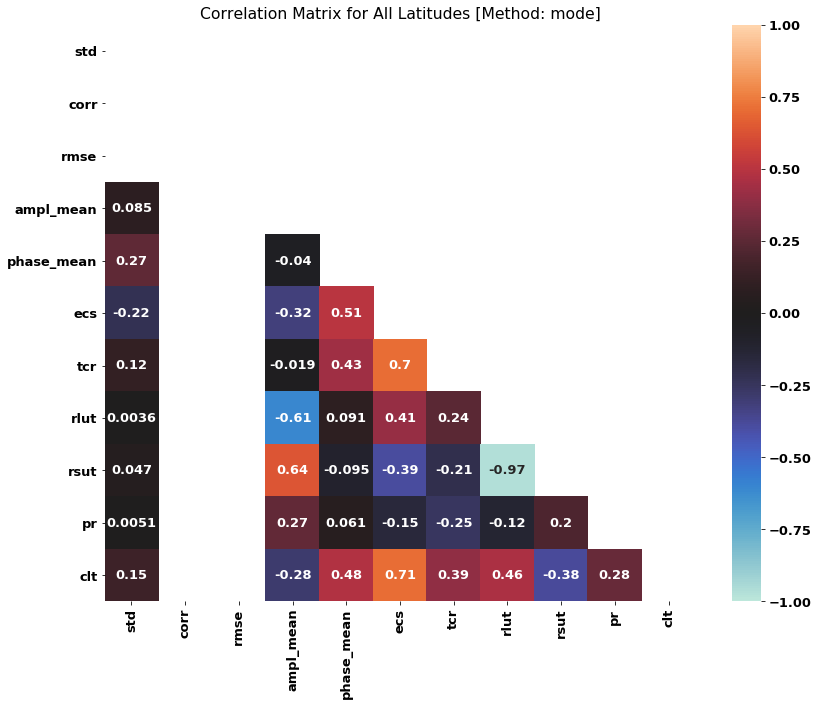

In [369]:
# model_error_stats_df #.reset_index('season')

corr_mat_ds = model_error_stats_df #.drop(['BCC-CSM2-MR']) #.drop(['GFDL-ESM2M', 'MIROC5'])

plt.figure(figsize = (12,10))
plt.title('Correlation Matrix for All Latitudes [Method: mode]')
upper_tr_mask = np.triu(corr_mat_ds.corr())
sns.heatmap(corr_mat_ds.corr(), annot = True, 
            vmin = -1, vmax = 1, center = 0, fmt='.2g',
            mask = upper_tr_mask)
plt.tight_layout()
# plt.savefig(save_figs_dir + 'corr_heatmaps/CMIP6/' + 'land_and_water_poleward_of_35.png', dpi = 300)

In [131]:
# model_error_stats_df
model_error_stats_df.sort_values('rmse')

std      corr      rmse  ampl_mean  phase_mean  ecs  tcr  \
MIROC4h         4.935417  0.571495  4.711712     0.0107         3.0  NaN  NaN   
GFDL-ESM2M      5.244988  0.602958  4.745600     0.0111         3.7  2.4  1.4   
GFDL-ESM2G      5.183277  0.600166  4.792253     0.0081         2.4  2.4  1.1   
inmcm4          4.644129  0.529824  4.977963     0.0087         4.5  2.1  1.3   
FGOALS-s2       5.949036  0.595528  4.990282     0.0113         3.9  4.2  2.4   
MIROC-ESM-CHEM  5.274119  0.559938  5.015190     0.0099         3.0  NaN  NaN   
MIROC-ESM       5.277491  0.560437  5.026126     0.0109         2.9  4.7  2.2   
FGOALS-g2       3.245250  0.371613  5.081416     0.0088         2.7  3.4  1.4   
MRI-CGCM3       5.958659  0.514205  5.087506     0.0085         4.5  2.6  1.6   
MRI-ESM1        5.897033  0.510624  5.119405     0.0078         4.0  NaN  NaN   
ACCESS1-3       4.343984  0.545520  5.210349     0.0103         3.7  3.5  1.6   
MIROC5          4.823806  0.532708  5.227316     0.0117         2.7  2.7  1.4   
ACCESS1-0       4.440248  0.529018  5.250902     0.0098         3.5  3.8  1.9   
HadGEM2-ES      4.341888  0.526954  5.267280     0.0097         3.0  4.6  2.5   
NorESM1-M       4.773972  0.558104  5.271781     0.0095         3.4  2.8  1.4   
CMCC-CM         5.034107  0.498533  5.279821     0.0097         7.0  NaN  NaN   
GISS-E2-H       4.754934  0.462454  5.314297     0.0087         3.1  2.3  1.7   
GISS-E2-R       4.832852  0.463416  5.327695     0.0081         3.4  2.1  1.5   
CNRM-CM5        4.680674  0.566536  5.362334     0.0089         6.0  3.3  2.0   
GFDL-CM3        4.560429  0.489353  5.397058     0.0093         2.3  4.0  1.9   
IPSL-CM5A-MR    4.645040  0.367659  5.691266     0.0111         1.5  NaN  2.0   
IPSL-CM5A-LR    4.782536  0.402402  5.711185     0.0101         1.8  4.1  2.0   

                rlut  rsut  pr  clt  
MIROC4h          NaN   NaN NaN  NaN  
GFDL-ESM2M       NaN   NaN NaN  NaN  
GFDL-ESM2G       NaN   NaN NaN  NaN  
inmcm4           NaN   NaN NaN  NaN  
FGOALS-s2        NaN   NaN NaN  NaN  
MIROC-ESM-CHEM   NaN   NaN NaN  NaN  
MIROC-ESM        NaN   NaN NaN  NaN  
FGOALS-g2        NaN   NaN NaN  NaN  
MRI-CGCM3        NaN   NaN NaN  NaN  
MRI-ESM1         NaN   NaN NaN  NaN  
ACCESS1-3        NaN   NaN NaN  NaN  
MIROC5           NaN   NaN NaN  NaN  
ACCESS1-0        NaN   NaN NaN  NaN  
HadGEM2-ES       NaN   NaN NaN  NaN  
NorESM1-M        NaN   NaN NaN  NaN  
CMCC-CM          NaN   NaN NaN  NaN  
GISS-E2-H        NaN   NaN NaN  NaN  
GISS-E2-R        NaN   NaN NaN  NaN  
CNRM-CM5         NaN   NaN NaN  NaN  
GFDL-CM3         NaN   NaN NaN  NaN  
IPSL-CM5A-MR     NaN   NaN NaN  NaN  
IPSL-CM5A-LR     NaN   NaN NaN  NaN

In [334]:
def metric_scatter(df, x_field = 'phase_mean', 
                   y_field = 'ecs',):
    plt.figure(figsize = (8,5))
    # for mod_ii in model_error_stats_df.iterrows():
    model_list = list(df.index)
    for ii in range(len(df)):
        mod_ii = df.iloc[ii,:]
        xx,yy = mod_ii[x_field], mod_ii[y_field]
        if (not np.isnan(xx)) & (not np.isnan(yy)):
    #         print(xx,yy)
            plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
            plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
    plt.grid()
    plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
    plt.xlabel('Phase Mean [Hours]')
    plt.ylabel('ECS')
    
    corr = df.corr()[x_field][y_field]
    print(corr)
#     plt.annotate('Correlation:' + '{:.3f}'.format(corr), xy=(1.05, -0.1), xycoords='axes fraction')
    plt.annotate('Corr:' + '{:.3f}'.format(corr), xy=(0.75, 0.01), xycoords='axes fraction')


    plt.tight_layout()

-0.1878302841012386
-0.17745722101824332
0.02886992781254619
0.013021722129358577


Text(38.0, 0.5, 'TCR')

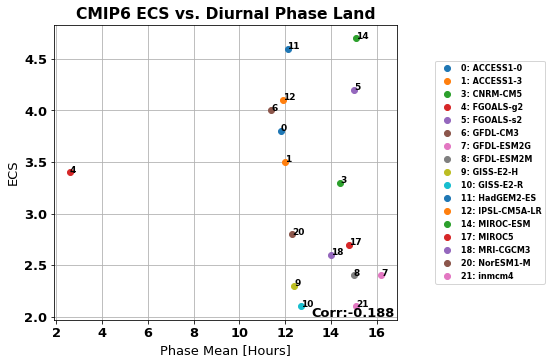

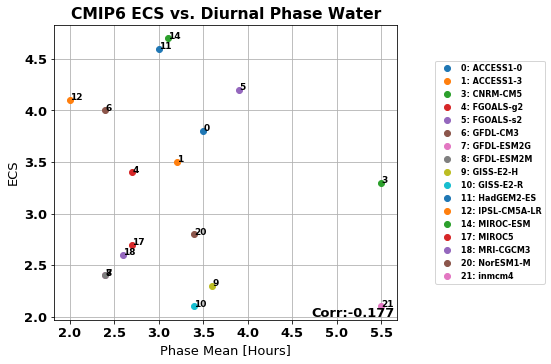

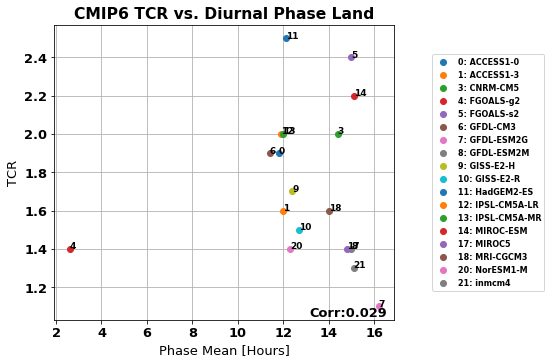

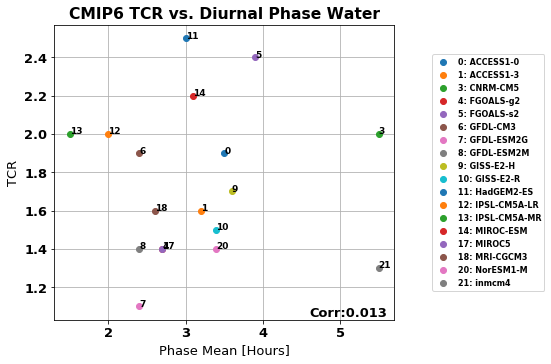

In [335]:

metric_scatter(model_error_stats_df_land)
plt.title('CMIP6 ECS vs. Diurnal Phase Land', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_land.png', dpi = 300)


metric_scatter(model_error_stats_df_water)
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'ecs_vs_phase_water_25n_25_s.png', dpi = 300)


metric_scatter(model_error_stats_df_land, y_field = 'tcr')
plt.title('CMIP6 TCR vs. Diurnal Phase Land', weight = 'bold')
plt.ylabel('TCR')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_land.png', dpi = 300)


metric_scatter(model_error_stats_df_water, y_field = 'tcr')
plt.title('CMIP6 TCR vs. Diurnal Phase Water', weight = 'bold')
plt.ylabel('TCR')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'tcr_vs_phase_water.png',  dpi = 300)



0.5076150951563545


(array([1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 8 Text xticklabel objects>)

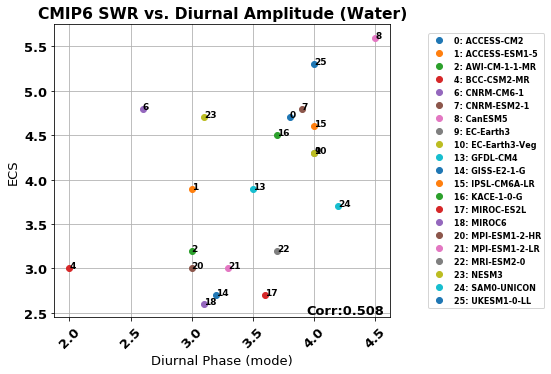

In [371]:
metric_scatter(model_error_stats_df,  x_field = 'phase_mean',  y_field = 'ecs')
plt.title('CMIP6 SWR vs. Diurnal Amplitude (Water)', weight = 'bold')

# plt.ylabel(r'SWR [$\frac{W}{m^2}$]')
# plt.ylabel
plt.xlabel('Diurnal Phase (mode)')
plt.xticks(rotation=45)
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP6/' + 'swr_vs_ampl_water.png', dpi = 300)




In [160]:
# sanity check modes
# mode_apply(df_cmip5[df_cmip5['model_name'] == 'GFDL-ESM2G'].round(1)['phase_season'])

['BCC-CSM2-MR']

-0.3198334269575965


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Aplitude')

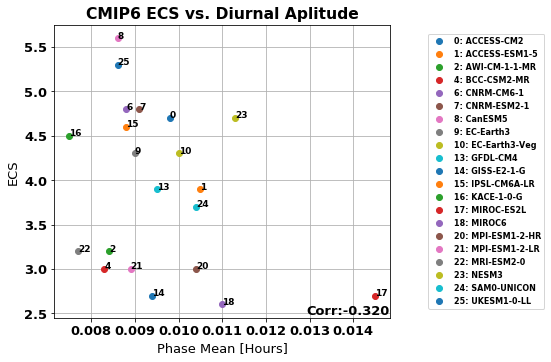

In [372]:
metric_scatter(model_error_stats_df,  
               y_field = 'ecs', x_field = 'ampl_mean')
plt.title('CMIP6 ECS vs. Diurnal Aplitude', weight = 'bold')
# plt.xlim([2.5, 4.5])
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)




In [233]:
# sanity check modes
mode_apply((df_cmip6[df_cmip6['model_name'] == 'ACCESS-ESM1-5'] *FLUX_TO_MM_HR).round(4)['ampl_season'])

0.0105

In [244]:
# model_error_stats_df['ampl_mean']
#  model_error_stats_df
# (df_cmip6[df_cmip6['model_name'] == 'ACCESS-ESM1-5']['ampl_season'] *FLUX_TO_MM_HR).round(4).plot.hist(bins = 300)

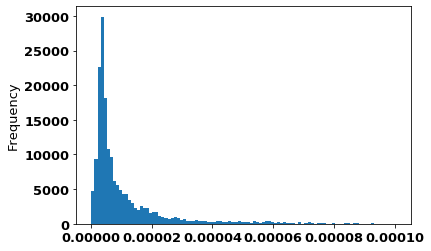

In [198]:
df_cmip6[df_cmip6['model_name'] == 'MIROC-ES2L']['ampl_season'].round(8).plot.hist(bins = 100)

-0.9643358090777581


Text(0.5, 1, 'CMIP6 ECS vs. Diurnal Phase Water')

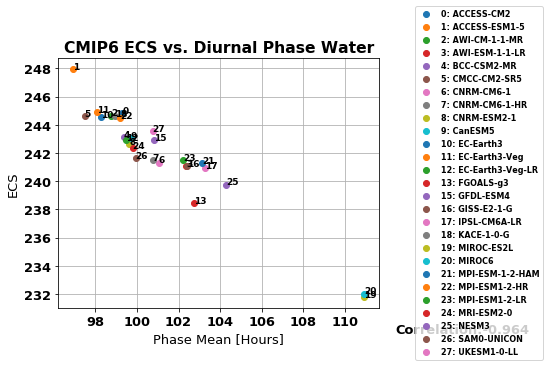

In [53]:
metric_scatter(model_error_stats_df,  y_field = 'rlut', x_field = 'rsut')
plt.title('CMIP6 ECS vs. Diurnal Phase Water', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/CMIP5/' + 'ecs_vs_ampl_water.png', dpi = 300)





0.8417335101239384


Text(0.5, 1, 'CMIP6 ECS vs. TCR')

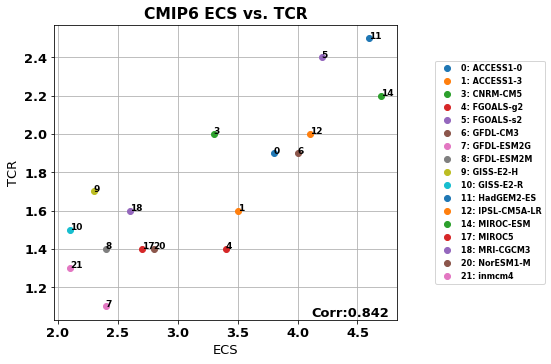

In [102]:
metric_scatter(model_error_stats_df, x_field = 'ecs', y_field = 'tcr' )
plt.xlabel('ECS')
plt.ylabel('TCR')
plt.title('CMIP6 ECS vs. TCR', weight = 'bold')
# plt.savefig(save_figs_dir + 'diurnal_vs_climate/' + 'ecs_vs_tcr_cmip6.png',  dpi = 300)



In [455]:
# # fig, ax = plt.subplots()
# plt.figure(figsize = (7,5))
# # for mod_ii in model_error_stats_df.iterrows():
# model_list = list(model_error_stats_df.index)
# for ii in range(len(model_error_stats_df)):
#     mod_ii = model_error_stats_df.iloc[ii,:]
#     xx,yy = mod_ii[x_field], mod_ii[y_field]
#     if (not np.isnan(xx)) & (not np.isnan(yy)):
# #         print(xx,yy)
#         plt.plot(xx, yy, 'o', label = str(ii) + ': ' + model_list[ii])
#         plt.annotate(str(ii), (xx, yy), size = 9, weight = 'bold')
# plt.grid()
# plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5),prop={'size': 8})
# plt.xlabel('Phase Mean')
# plt.ylabel('ECS')
# plt.tight_layout()

In [456]:
model_error_stats_df.corr()

0.5673670369844968

In [43]:
# np.corrcoef
# model_error_stats
# plt.imshow(df_i[field].values * (2*np.pi/24), origin = 'lower')
def sin_hour(hours):
    '''Give array of hours, convert sin quanitity to deal with cirular quantity'''
    return np.sin(hours*HOURS_TO_RADIANS)
# df_i[field].values * HOURS_TO_RADIANS

In [370]:
# xx = np.arange(0, 24,0.01)
# plt.plot(xx, sin_hour(xx))

In [371]:
# _ = plt.hist(sin_hour(df[df['model_name'] == model_name][field].values), bins = 200)

In [372]:
# sin_hour(6)

In [373]:
# _ = plt.hist(df[df['model_name'] == model_name][field].values, bins =200)

array([[ 1.        , -0.53193993],
       [-0.53193993,  1.        ]])

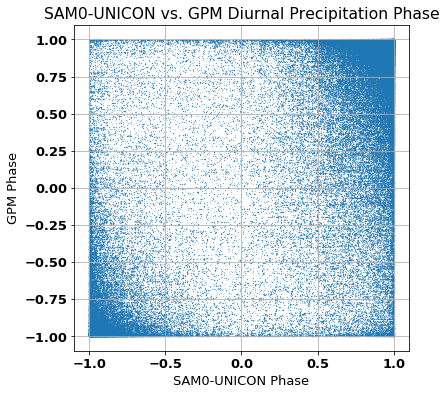

In [356]:
field = 'phase_season'
model_name = 'SAM0-UNICON'
plt.figure(figsize = (6,6))
plt.scatter(sin_hour(df[df['model_name'] == model_name][field].values), 
            sin_hour(df_gpm[field].values), 
            s=0.02)
plt.xlabel(model_name + ' Phase')
plt.ylabel('GPM Phase')
plt.title( model_name + ' vs. GPM Diurnal Precipitation Phase')
plt.grid()
np.corrcoef(sin_hour(df[df['model_name'] == model_name][field].values), df_gpm[field].values)
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'sample_scatter_phases.png', dpi = 300)

array([[ 1.        , -0.25302769],
       [-0.25302769,  1.        ]])

In [70]:
# df.groupby('season')

In [185]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

In [245]:
df

mu_season  sigma_season  ampl_season  phase_season  \
lat   lon                                                         
-60.0 0.0     0.000017      0.000001     0.000002      0.524775   
      0.0     0.000030      0.000002     0.000003      2.190587   
      0.0     0.000032      0.000002     0.000002      2.044747   
      0.0     0.000027      0.000001     0.000001     21.782672   
      0.0     0.000024      0.000002     0.000002      0.660006   
...                ...           ...          ...           ...   
 59.5 359.5   0.000039      0.000002     0.000002     23.090859   
      359.5   0.000034      0.000002     0.000002      2.330588   
      359.5   0.000041      0.000003     0.000004      2.125144   
      359.5   0.000037      0.000003     0.000003      1.820820   
      359.5   0.000031      0.000003     0.000003      1.394879   

                model_name cmip_indentifier  land_sea_mask  
lat   lon                                                   
-60.0 0.0        FGOALS-g2            CMIP5              0  
      0.0           MIROC5            CMIP5              0  
      0.0           inmcm4            CMIP5              0  
      0.0          MIROC4h            CMIP5              0  
      0.0          CMCC-CM            CMIP5              0  
...                    ...              ...            ...  
 59.5 359.5    SAM0-UNICON            CMIP6              0  
      359.5         MIROC6            CMIP6              0  
      359.5  ACCESS-ESM1-5            CMIP6              0  
      359.5     ACCESS-CM2            CMIP6              0  
      359.5          NESM3            CMIP6              0  

[6048000 rows x 7 columns]

In [248]:
# gpm_std
sorted(df[df['cmip_indentifier'] == 'CMIP6']['model_name'].unique())

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'AWI-ESM-1-1-LR',
 'BCC-CSM2-MR',
 'CMCC-CM2-SR5',
 'EC-Earth3',
 'EC-Earth3-Veg-LR',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'SAM0-UNICON']

In [227]:
model_error_stats.head()

std      corr      rmse  ampl_mean  phase_mean  ecs
ACCESS-CM2      4.980532  0.194987  6.495437   0.036648   13.152773  4.7
ACCESS-ESM1-5   3.295360  0.211391  6.934853   0.054257   12.834726  3.9
AWI-CM-1-1-MR   2.778771  0.196295  7.022509   0.060849   12.878386  3.2
AWI-ESM-1-1-LR  2.797228  0.178002  6.945988        NaN         NaN  NaN
BCC-CSM2-MR     5.775114  0.221402  6.635449   0.021344   12.312652  3.0

In [242]:
# model_error_stats['ACCESS-CM2']
model_error_stats.loc["ACCESS-CM2",:]
# model_error_stats.index[0]

std            4.980532
corr           0.194987
rmse           6.495437
ampl_mean      0.036648
phase_mean    13.152773
ecs            4.700000
Name: ACCESS-CM2, dtype: float64

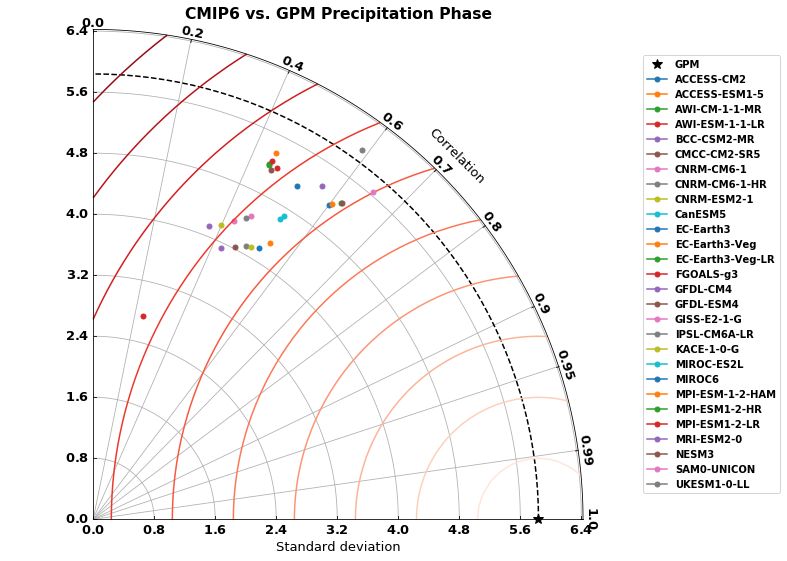

In [139]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP6 vs. GPM Precipitation Phase', weight = 'bold')
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_water.png', dpi = 300)

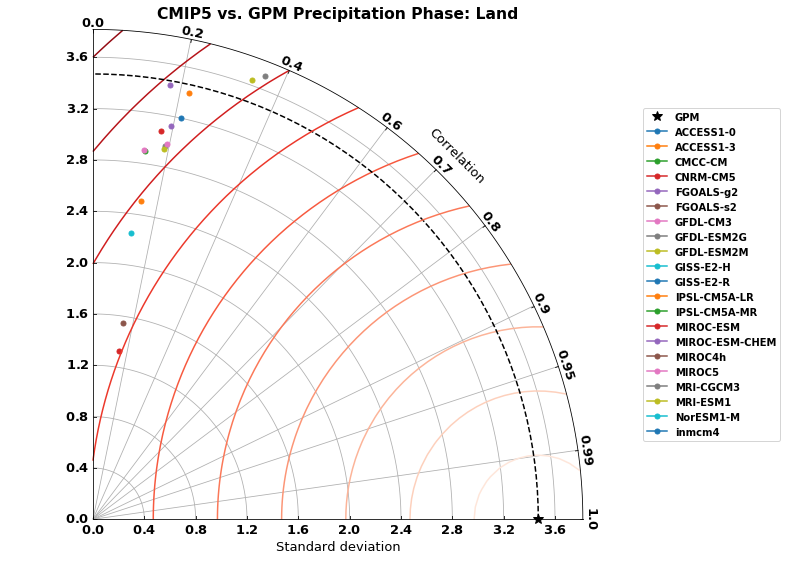

In [150]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_land_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 1.1)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats_df_land.index):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats_df_land.loc[model_name,:]['std'], 
                           corrcoef = model_error_stats_df_land.loc[model_name,:]['corr'], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
plt.title('CMIP5 vs. GPM Precipitation Phase: Land', weight = 'bold')
plt.tight_layout()

plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5_land.png', dpi = 300)

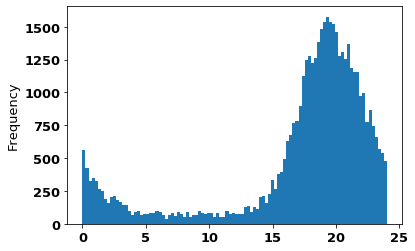

In [184]:
df_for_stats_true_land['phase_season'].plot.hist(bins = 100)

In [194]:
df

mu_season  sigma_season  ampl_season  phase_season  \
lat   lon                                                         
-60.0 0.0     0.000029      0.000002     0.000002      2.409531   
      0.0     0.000024      0.000001     0.000002      5.032166   
      0.0     0.000025      0.000002     0.000002      3.635818   
      0.0     0.000025      0.000001     0.000002      2.712281   
      0.0     0.000024      0.000002     0.000002      1.638110   
...                ...           ...          ...           ...   
 59.5 359.5   0.000023      0.000002     0.000002     21.499995   
      359.5   0.000041      0.000003     0.000004      2.060632   
      359.5   0.000037      0.000003     0.000003      1.820820   
      359.5   0.000041      0.000003     0.000004      3.159079   
      359.5   0.000031      0.000002     0.000003      3.532080   

                model_name cmip_indentifier  land_sea_mask  
lat   lon                                                   
-60.0 0.0           MIROC5            CMIP5              0  
      0.0         MRI-ESM1            CMIP5              0  
      0.0        ACCESS1-3            CMIP5              0  
      0.0       HadGEM2-ES            CMIP5              0  
      0.0          CMCC-CM            CMIP5              0  
...                    ...              ...            ...  
 59.5 359.5    GISS-E2-1-G            CMIP6              0  
      359.5  AWI-CM-1-1-MR            CMIP6              0  
      359.5     ACCESS-CM2            CMIP6              0  
      359.5  ACCESS-ESM1-5            CMIP6              0  
      359.5     KACE-1-0-G            CMIP6              0  

[8640000 rows x 7 columns]

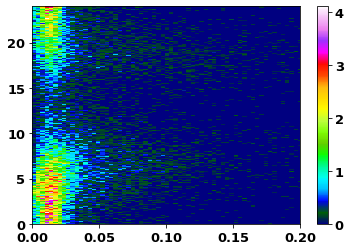

In [100]:
# mode_apply(df_for_stats_true_water['phase_season'])
# df_for_stats_true.plot(x = 'ampl_season', y = 'phase_season' , kind = 'scatter')
# sns.jointplot('ampl_season', 'phase_season', data = df_for_stats_true, 
#               kind = 'hex', xlim = [0, 0.2])
_ = plt.hist2d(df_for_stats_true['ampl_season'], df_for_stats_true['phase_season'], bins = 300,
              density = True, cmap = plt.get_cmap('gist_ncar'))
plt.xlim([0, 0.2])
plt.colorbar()

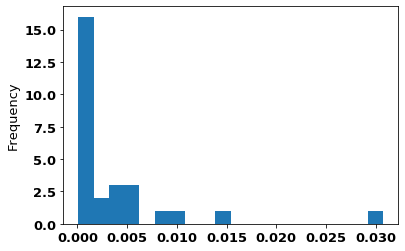

In [258]:
model_error_stats_df_land['ampl_mean'].plot.hist(bins = 20)

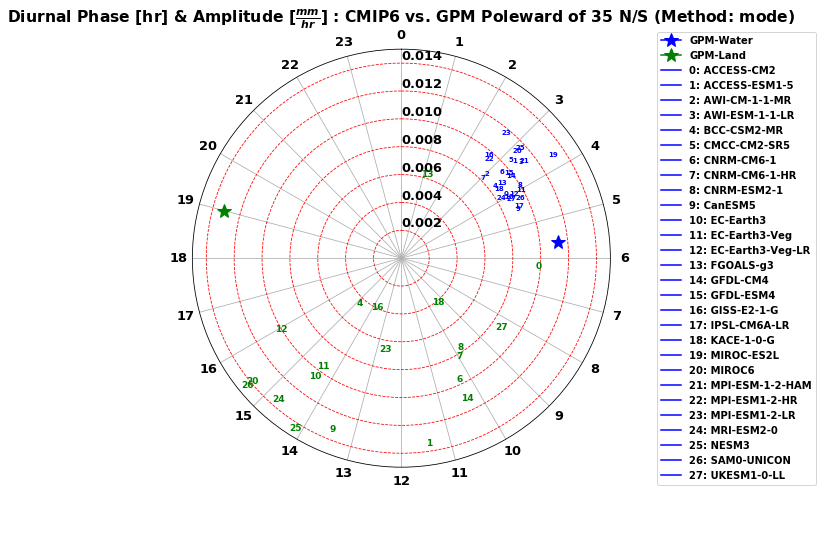

In [363]:
%run phaseDiagram.py

fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = PhaseDiagram(gpm_water_std, 
                          fig = fig, 
                          label = 'GPM', 
                          y_lim=(0, 0.015),
                          radial_label_pos = 0
                          )
taylor_diag.add_grid()

taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_water['phase_season'].round(1)), 
                           ampl = mode_apply(df_for_stats_true_water['ampl_season'].round(4)), 
                           marker = '*', 
                           c = 'b',
                           label = 'GPM-Water', 
                           markersize = 15)

taylor_diag.add_sample(phase = mode_apply(df_for_stats_true_land['phase_season'].round(1)), 
                           ampl = mode_apply(df_for_stats_true_land['ampl_season'].round(4)), 
                           marker = '*', 
                           c = 'g',
                           label = 'GPM-Land', 
                           markersize = 15)

# plot model points 
model_list = list(model_error_stats_df_water.index)
for model_name_i in range(len(model_list)):
#     print(model_error_stats[model_name])
#     print(model_error_stats_df.loc[model_name,:]['phase_mean'])
    phase_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_water.loc[model_list[model_name_i],:]['ampl_mean']

    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None,
                           linestyle = None,
                           c = 'b',
                           label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           markersize = 1)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         label = str(model_name_i) + ': ' + model_list[model_name_i], 
                         c = 'b',
                         size = 7,
                         weight = 'bold')
    
for model_name_i in range(len(model_list)):

    phase_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['phase_mean']
    ampl_i = model_error_stats_df_land.loc[model_list[model_name_i],:]['ampl_mean']

    taylor_diag.add_sample(phase = phase_i, 
                           ampl = ampl_i, 
                           marker = None, 
                           c = 'g',
                           linestyle = None,
#                            label = str(model_name_i) + ': ' + model_list[model_name_i], 
                           label = None,
                           markersize = 1)
    taylor_diag.add_text(phase = phase_i, 
                         ampl = ampl_i,
                         text = model_name_i,
                         c = 'g',
                         size = 9,
                         weight = 'bold')


# plt.legend()
leg = plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5), prop={'size': 10})
# for n, text in enumerate(leg.markerscale):
#     print( n, text)
#     text.set_color( color_l[n] )

plt.title(r'Diurnal Phase [hr] & Amplitude [$\frac{mm}{hr}$] : CMIP6 vs. GPM Poleward of 35 N/S (Method: mode)', weight = 'bold')
plt.tight_layout()

plt.savefig(save_figs_dir + 'phase_ampl_plots/CMIP6/' + 'all_cmip6_land_water_pw_35NS.png', dpi = 300)

In [424]:
leg.markerscale

1.0

In [422]:
leg.

In [324]:
axx = taylor_diag.get_ax()

In [325]:
axx.

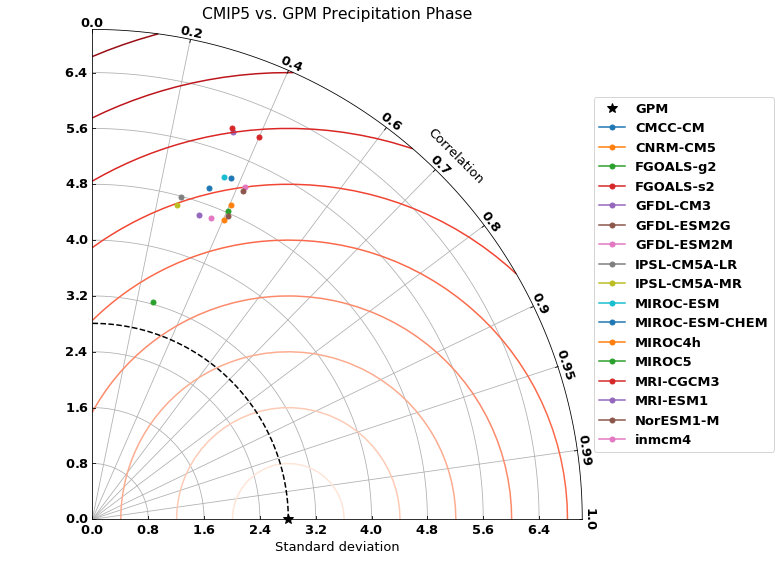

In [165]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)